In [7]:
%matplotlib inline

import logging
from pathlib import Path
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from tqdm import trange
import wandb

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision

import torch_geometric.utils

from experiments.data import INRDataset
from experiments.utils import count_parameters, set_logger, set_seed
from experiments.lr_scheduler import WarmupLRScheduler
from nn.relational_transformer import RelationalTransformer

from nn.gnn import GNNForClassification
from nn.dws.models import MLPModelForClassification
from nn.inr import INRPerLayer

set_logger()



# Data preprocessing

In [22]:
!python ./neural-graphs/experiments/inr_classification/dataset/generate_mnist_data_splits.py --data-path mnist-inrs --save-path . --name mnist_splits.json

2024-06-04 17:57:17,575 - root - INFO - train size: 55000, val size: 5000, test size: 10000


In [23]:
!python ./neural-graphs/experiments/inr_classification/dataset/compute_mnist_statistics.py --splits-path mnist_splits.json --statistics-path mnist_statistics.pth

weights_mean: [-4.6946126531111076e-05, -4.879618842323907e-08, 7.019223994575441e-05]
weights_std: [0.06281439960002899, 0.018272986635565758, 0.11789131909608841]
biases_mean: [1.6350102669093758e-05, 6.972527444304433e-06, -0.012316767126321793]
biases_std: [0.021335216239094734, 0.011009006761014462, 0.09988907724618912]


# INR Dataset
[Blog on Implicit Neural Representations ](https://medium.com/@nathaliemariehager/an-introduction-to-neural-implicit-representations-with-use-cases-ad331ca12907)


In [53]:
dataset_dir = "./neural-graphs/experiments/inr_classification/dataset"
splits_path = "mnist_splits.json"
statistics_path = "mnist_statistics.pth"

img_shape = (28, 28)
batch_size = 2

In [54]:
orig_mnist = torchvision.datasets.MNIST(
    Path(dataset_dir)/"mnist",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

In [55]:
from torchvision.utils import save_image, make_grid

from experiments.data import BatchSiren, INRDataset

dataset = INRDataset(
    dataset_dir = dataset_dir,
    split="train",
    normalize=False,
    augmentation=False,
    splits_path=splits_path,
    statistics_path=statistics_path,
)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
batch = next(iter(loader))

dataset_aug = INRDataset(
    dataset_dir=dataset_dir,
    split="train",
    normalize=False,
    augmentation=True,
    splits_path=splits_path,
    statistics_path=statistics_path,
)

loader_aug = torch.utils.data.DataLoader(
    dataset_aug, batch_size=batch_size, shuffle=False
)
batch_aug = next(iter(loader_aug))

print(len(batch.weights))
print(batch.weights[0].shape)
print(len(batch.biases))
print(batch.biases[0].shape)

3
torch.Size([2, 2, 32, 1])
3
torch.Size([2, 32, 1])


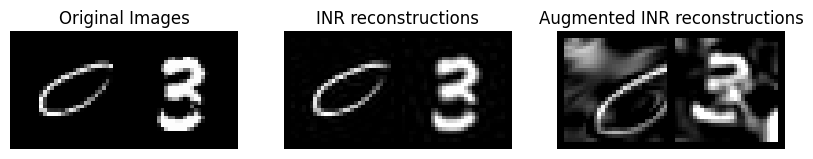

In [56]:
inr_model = BatchSiren(2, 1, img_shape=img_shape)
# The inr_model takes in weights and reconstructs the inr_representation to explicit form.
out = inr_model(batch.weights, batch.biases)
out = out.transpose(1, 2).unflatten(2, img_shape)

out_aug = inr_model(batch_aug.weights, batch_aug.biases)
out_aug = out_aug.transpose(1, 2).unflatten(2, img_shape)

indices = [
    int(p.parts[-3].split("_")[-1]) for p in dataset.dataset["path"][:batch_size]
]
orig_images = [orig_mnist[idx][0] for idx in indices]

fig, ax = plt.subplots(1, 3, figsize=(10, 20))

ax[0].imshow(make_grid(orig_images).permute(1, 2, 0).clip(0, 1))
ax[0].set_title("Original Images")
ax[0].set_axis_off()

ax[1].imshow(make_grid(out).permute(1, 2, 0).clip(0, 1))
ax[1].set_title("INR reconstructions")
ax[1].set_axis_off()

ax[2].imshow(make_grid(out_aug).permute(1, 2, 0).clip(0, 1))
ax[2].set_title("Augmented INR reconstructions")
ax[2].set_axis_off()

# Train, Val, Test Datasets

In [57]:
train_set = INRDataset(
    dataset_dir=dataset_dir,
    split="train",
    normalize=False,
    augmentation=True,
    splits_path=splits_path,
    statistics_path=statistics_path,
)

val_set = INRDataset(
    dataset_dir=dataset_dir,
    split="val",
    normalize=False,
    splits_path=splits_path,
    statistics_path=statistics_path,
)

test_set = INRDataset(
    dataset_dir=dataset_dir,
    split="test",
    normalize=False,
    splits_path=splits_path,
    statistics_path=statistics_path,
)

# DataLoaders


In [60]:
batch_size = 64
num_workers = 8

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

2024-06-04 22:05:03,218 - root - INFO - train size 55000, val size 5000, test size 10000


Look at input INR's shapes: weight matrices are of shape (in_dim, out_dim, channels),
and biases are of shape (out_dim, channels).

In [67]:
print(train_set[0].as_dict().keys())
point = train_set[0]

print("Weights:", [w.shape for w in point.weights])
print("Biases:", [b.shape for b in point.biases])

dict_keys(['weights', 'biases', 'label'])
Weights: [torch.Size([2, 32, 1]), torch.Size([32, 32, 1]), torch.Size([32, 1, 1])]
Biases: [torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([1, 1])]


### Initialize Neural Graphs Transformer

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"device = {device}")

2024-06-04 22:10:15,148 - root - INFO - device = cpu


In [71]:
# Compute the layer layout
point = train_set[0]
weight_shapes = tuple(weight.shape[:2] for weight in point.weights)
bias_shapes = tuple(bias.shape[:1] for bias in point.biases)

print(weight_shapes)
print(bias_shapes)

layer_layout = [weight_shapes[0][0]] + [b[0] for b in bias_shapes]

logging.info(f"weight shapes: {weight_shapes}, bias shapes: {bias_shapes}, layer_layout: {layer_layout}")

2024-06-04 22:15:48,004 - root - INFO - weight shapes: (torch.Size([2, 32]), torch.Size([32, 32]), torch.Size([32, 1])), bias shapes: (torch.Size([32]), torch.Size([32]), torch.Size([1])), layer_layout: [2, 32, 32, 1]


(torch.Size([2, 32]), torch.Size([32, 32]), torch.Size([32, 1]))
(torch.Size([32]), torch.Size([32]), torch.Size([1]))


In [72]:
stats = {
    "weights_mean": [
        -4.215954686515033e-05,
        -7.55547659991862e-07,
        7.886120874900371e-05,
    ],
    "weights_std": [0.06281130015850067, 0.018268151208758354, 0.11791174858808517],
    "biases_mean": [
        5.419965418695938e-06,
        3.7173406326473923e-06,
        -0.01239530649036169,
    ],
    "biases_std": [0.021334609016776085, 0.011004417203366756, 0.09989194571971893],
}

In [74]:
# inr_model = INRPerLayer(n_layers=3, up_scale=16, out_channels=1)

inr_model = None
d_node = 64
d_edge = 32

graph_constructor = OmegaConf.create(
    {
        "_target_": "nn.graph_constructor.GraphConstructor",
        "_recursive_": False,
        "_convert_": "all",
        "d_in": 1,
        "d_edge_in": 1,
        "zero_out_bias": False,
        "zero_out_weights": False,
        "sin_emb": True,
        "sin_emb_dim": 128,
        "use_pos_embed": True,
        "input_layers": 1,
        "inp_factor": 1,
        "num_probe_features": 0,
        "inr_model": inr_model,
        "stats": stats,
    }
)

model = RelationalTransformer(
    d_node=d_node,
    d_edge=d_edge,
    d_attn_hid=128,
    d_node_hid=128,
    d_edge_hid=64,
    d_out_hid=128,
    d_out=10,
    n_layers=4,
    n_heads=8,
    layer_layout=layer_layout,
    graph_constructor=graph_constructor,
    dropout=0.0,
    use_cls_token=False,
    pooling_method="cat",
    pooling_layer_idx="last",
).to(device)

logging.info(f"number of parameters: {count_parameters(model)}")

2024-06-04 22:19:49,230 - root - INFO - number of parameters: 376586


### Eval Function

In [75]:
@torch.no_grad()
def evaluate(model, loader, device, num_batches=None):
    model.eval()
    loss = 0.0
    correct = 0.0
    total = 0.0
    predicted, gt = [], []
    for i, batch in enumerate(loader):
        if num_batches is not None and i >= num_batches:
            break
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += F.cross_entropy(out, batch.label, reduction="sum")
        total += len(batch.label)
        pred = out.argmax(1)
        correct += pred.eq(batch.label).sum()
        predicted.extend(pred.cpu().numpy().tolist())
        gt.extend(batch.label.cpu().numpy().tolist())
        
    model.train()
    avg_loss = loss/total
    avg_acc = correct/total
    
    return dict(avg_loss=avg_loss, avg_acc=avg_acc, predicted=predicted, gt=gt)


### Model Training

In [76]:
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(
    params=parameters, lr=1e-3, amsgrad=True, weight_decay=5e-4, fused=False
)

scheduler = WarmupLRScheduler(warmup_steps=1000, optimizer=optimizer)

/Users/subhashp/Documents/Practice/GNN-Primer/.env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [80]:
epochs = 5
eval_every = 1

global_step = 0
criterion = nn.CrossEntropyLoss()

val_acc = -1
val_loss = float("inf")
best_val_acc = -1
best_val_loss = float("inf")

In [81]:
epoch_iter = trange(epochs)

for epoch in epoch_iter:
    for i, batch in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        label = batch.label
        
        out = model(inputs)
        loss = criterion(out, label)
        loss.backward()
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
            
        epoch_iter.set_description(
            f"[{epoch}{i+1}], train loss: {loss.item():.3f}, val loss: {val_loss:.3f}, val acc: {val_acc:.3f}, "
            f"best val loss: {best_val_loss:.3f}, best val acc: {best_val_acc:.3f}"
        )
        
        global_step += 1
        
        if (global_step + 1) % eval_every == 0:
            val_loss_dict = evaluate(model, val_loader, device)
            val_loss = val_loss_dict["avg_loss"]
            val_acc = val_loss_dict["avg_acc"]
            
            if val_acc >= best_val_acc:
                best_val_acc = val_acc
                best_val_loss = val_loss

[05], train loss: 2.342, val loss: 2.330, val acc: 0.092, best val loss: 2.330, best val acc: 0.092:   0%|          | 0/5 [10:25<?, ?it/s]

In [ ]:
test_loss_dict = evaluate(model, test_loader, device)
test_loss = test_loss_dict["avg_loss"]
test_acc = test_loss_dict["avg_acc"]

logging.info(
    f"[{epoch} {i+1}], train loss: {loss.item():.3f}, test loss: {test_loss:.3f}, test acc: {test_acc:.3f}"
)